# Data Processing

## 1. Labeling

The datasets used in this section are:
- [project.cvs](https://github.com/GokuMohandas/Made-With-ML/blob/main/datasets/projects.csv): projects with id, create time, title and description.
- [tags.csv](https://github.com/GokuMohandas/Made-With-ML/blob/main/datasets/tags.csv): labels for project by id

In [1]:
import pandas as pd

In [5]:
# file links
PROJECT_URL = "https://raw.githubusercontent.com/GokuMohandas/Made-With-ML/main/datasets/projects.csv"
TAGS_URL = "https://raw.githubusercontent.com/GokuMohandas/Made-With-ML/main/datasets/tags.csv"

In [6]:
projects = pd.read_csv(PROJECT_URL)
projects.head(5)

,id,created_on,title,description
0,6,2020-02-20 06:43:18,Comparison between YOLO and RCNN on real world...,Bringing theory to experiment is cool. We can ...
1,7,2020-02-20 06:47:21,"Show, Infer & Tell: Contextual Inference for C...",The beauty of the work lies in the way it arch...
2,9,2020-02-24 16:24:45,Awesome Graph Classification,"A collection of important graph embedding, cla..."
3,15,2020-02-28 23:55:26,Awesome Monte Carlo Tree Search,A curated list of Monte Carlo tree search pape...
4,19,2020-03-03 13:54:31,Diffusion to Vector,Reference implementation of Diffusion2Vec (Com...


In [8]:
tags = pd.read_csv(TAGS_URL)
tags.head(5)

,id,tag
0,6,computer-vision
1,7,computer-vision
2,9,graph-learning
3,15,reinforcement-learning
4,19,graph-learning


In [9]:
df = pd.merge(projects, tags, on="id")
df.head()

,id,created_on,title,description,tag
0,6,2020-02-20 06:43:18,Comparison between YOLO and RCNN on real world...,Bringing theory to experiment is cool. We can ...,computer-vision
1,7,2020-02-20 06:47:21,"Show, Infer & Tell: Contextual Inference for C...",The beauty of the work lies in the way it arch...,computer-vision
2,9,2020-02-24 16:24:45,Awesome Graph Classification,"A collection of important graph embedding, cla...",graph-learning
3,15,2020-02-28 23:55:26,Awesome Monte Carlo Tree Search,A curated list of Monte Carlo tree search pape...,reinforcement-learning
4,19,2020-03-03 13:54:31,Diffusion to Vector,Reference implementation of Diffusion2Vec (Com...,graph-learning


In [11]:
# remove projects with no tag
df = df[df.tag.notnull()]

In [12]:
# exporting data
df.to_csv("labeled_projects.csv", index=False)

## 2. Exploration (EDA)

EDA - Exploratory data analysis, aims to understand the signals and nuances of the dataset. **It is a cyclical process that can be done at various points of our development process.** For instance, if we're unsure how to label or preprocess out data, we can use EDA to figure it out.

In [2]:
df = pd.read_csv("labeled_projects.csv")

In [3]:
from collections import Counter
import ipywidgets as widgets
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from wordcloud import WordCloud, STOPWORDS
sns.set_theme()
warnings.filterwarnings("ignore")

In [4]:
# Distribution of tags
tags, tag_counts = zip(*Counter(df.tag.values).most_common())
print("Tags: ", list(tags))
print("\nTag counts: ", list(tag_counts))

Tags:  ['natural-language-processing', 'computer-vision', 'mlops', 'reinforcement-learning', 'graph-learning', 'time-series']

Tag counts:  [388, 356, 79, 56, 45, 31]


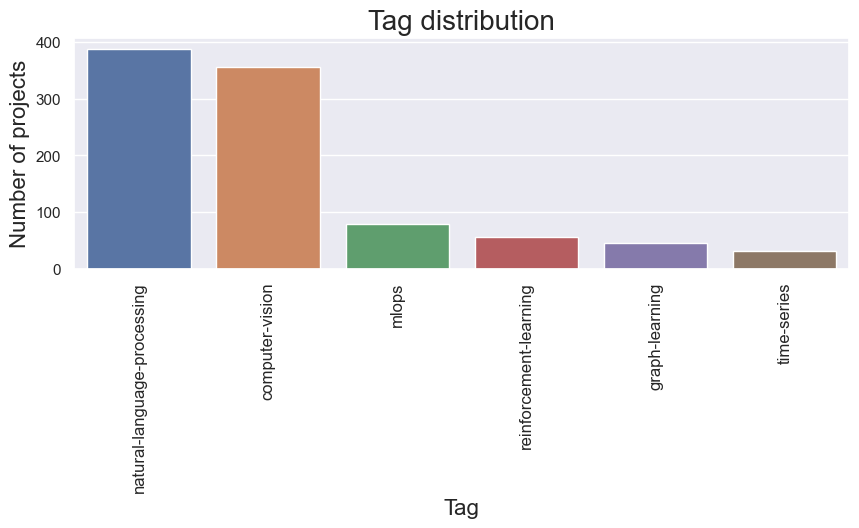

In [5]:
plt.figure(figsize=(10, 3))
ax = sns.barplot(pd.DataFrame({"tags": tags, "counts": tag_counts}),
                 x="tags", y="counts")
plt.title("Tag distribution", fontsize=20)
plt.xlabel("Tag", fontsize=16)
ax.set_xticklabels(tags, rotation=90, fontsize=12)
plt.ylabel("Number of projects", fontsize=16)
plt.show()

*It's quiute obvious that there's a data imbalance in our dataset. We'll address this issue later.*

In [7]:
# Most frequent tokens for each tag
@widgets.interact(tag=list(tags))
def display_word_could(tag="natural-language-processing"):
    plt.figure(figsize=(15, 5))
    subset = df[df.tag==tag]
    text = subset.description.values
    cloud = WordCloud(
        stopwords=STOPWORDS, background_color="black", collocations=False,
        width=500, height=300
        ).generate(" ".join(text))
    plt.axis("off")
    plt.imshow(cloud)

interactive(children=(Dropdown(description='tag', options=('natural-language-processing', 'computer-vision', '…

## 3. Preprocessing

- Global steps: don't depend on our dataset, ex. lower casing text, removing stop words, etc.
- Local steps: constructs are learned only from the training split, ex. vocabulary, standardization, etc.

In [8]:
df.head()

,id,created_on,title,description,tag
0,6,2020-02-20 06:43:18,Comparison between YOLO and RCNN on real world...,Bringing theory to experiment is cool. We can ...,computer-vision
1,7,2020-02-20 06:47:21,"Show, Infer & Tell: Contextual Inference for C...",The beauty of the work lies in the way it arch...,computer-vision
2,9,2020-02-24 16:24:45,Awesome Graph Classification,"A collection of important graph embedding, cla...",graph-learning
3,15,2020-02-28 23:55:26,Awesome Monte Carlo Tree Search,A curated list of Monte Carlo tree search pape...,reinforcement-learning
4,19,2020-03-03 13:54:31,Diffusion to Vector,Reference implementation of Diffusion2Vec (Com...,graph-learning


### Feature engineering

Combining existing input features to create new meaningful signal

In [9]:
df["text"] = df.title + " " + df.description

### Cleaning

In [13]:
import json
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re

In [15]:
nltk.download("stopwords")
STOPWORDS = stopwords.words("english")
stemmer = PorterStemmer()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/tingsongou/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In natural language processing (NLP), **stop words** refer to the words that are commonly used in a language, but typically do not carry much meaning and therefore can be excluded from text analysis without sacrificing the overall understanding of the text. Examples of stop words in English include "the", "and", "a", "an", "in", "of", "on", "is", "was", "were", and "to", among others.

Stop words are often removed from text data during pre-processing, as they can cause noise and unnecessary complexity in downstream NLP tasks such as text classification, sentiment analysis, and information retrieval. However, whether or not to remove stop words depends on the specific application and analysis goals, as some tasks may require the inclusion of certain stop words in order to capture relevant information.

**Stemming** in NLP (Natural Language Processing) is the process of reducing words to their base or root form. The base or root form of a word is called a "stem". For example, the stem of the word "jumping" is "jump", and the stem of the word "swimming" is "swim".

The purpose of stemming is to group together words that have the same root meaning, but may have different inflections or suffixes. For example, the words "jumped", "jumps", and "jumping" all have the same root meaning, and stemming would reduce them to the same stem "jump".

In [16]:
print(STOPWORDS)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [38]:
def clean_text(text, lower=True, stem=False, stopwords=STOPWORDS):
    # clean raw text
    if lower:
        text = text.lower()
    # remove stop words
    if len(stopwords):
        pattern = re.compile(r"\b(" + r"|".join(STOPWORDS) + r")\b\s*")
        text = pattern.sub('', text)
    # spacing and filters
    text = re.sub(
        r"([!\"'#$%&()*\+,-./:;<=>?@\\\[\]^_`{|}~])", r" \1 ", text
        )
    text = re.sub("[^A-Za-z0-9]+", " ", text) # remove non alphanumeric chars
    text = re.sub(" +", " ", text)  # remove multiple spaces
    text = text.strip()  # strip white space at the ends
    
    # remove links
    text = re.sub(r"http\S+", "", text)
    
    # stemming
    if stem:
        text = " ".join([stemmer.stem(word, to_lowercase=lower) for word in text.split(" ")])
    
    return text

In [39]:
@widgets.interact(lower=True, stem=False)
def display_cleaned_text(lower, stem):
    text = "Conditional image generation using Variational Autoencoders and GANs."
    cleaned_text = clean_text(text=text, lower=lower, stem=stem)
    print(cleaned_text)  

interactive(children=(Checkbox(value=True, description='lower'), Checkbox(value=False, description='stem'), Ou…

In [40]:
# Apply to dataframe
original_df = df.copy()
df.text = df.text.apply(clean_text, lower=True, stem=False)
print(f"{original_df.text.values[0]}\n{df.text.values[0]}")

Comparison between YOLO and RCNN on real world videos Bringing theory to experiment is cool. We can easily train models in colab and find the results in minutes.
comparison yolo rcnn real world videos bringing theory experiment cool easily train models colab find results minutes
